<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S6/blob/master/image%20with%20L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:

import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             576
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector = torch.rand_like(param)*0
      reg_loss += l1_crit(param, zero_vector)

    factor = 0.0001
    loss += factor * reg_loss
    train_losses.append(loss)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.13985209167003632 Batch_id=468 Accuracy=93.04: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0887, Accuracy: 9706/10000 (97.06%)

EPOCH: 1


Loss=0.13178685307502747 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.1574130803346634 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:13<00:00, 42.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9833/10000 (98.33%)

EPOCH: 3


Loss=0.10634925961494446 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 41.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


Loss=0.17764157056808472 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9859/10000 (98.59%)

EPOCH: 5


Loss=0.20226645469665527 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9850/10000 (98.50%)

EPOCH: 6


Loss=0.11035741120576859 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9880/10000 (98.80%)

EPOCH: 7


Loss=0.12482671439647675 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Loss=0.148859903216362 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9880/10000 (98.80%)

EPOCH: 9


Loss=0.1097930520772934 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.12519106268882751 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 42.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9874/10000 (98.74%)

EPOCH: 11


Loss=0.15348270535469055 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9880/10000 (98.80%)

EPOCH: 12


Loss=0.1383601427078247 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.1253371387720108 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9893/10000 (98.93%)

EPOCH: 14


Loss=0.14992648363113403 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9873/10000 (98.73%)

EPOCH: 15


Loss=0.10342231392860413 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9911/10000 (99.11%)

EPOCH: 16


Loss=0.11836525797843933 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 17


Loss=0.15881532430648804 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)

EPOCH: 18


Loss=0.1229848563671112 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.13311760127544403 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9896/10000 (98.96%)

EPOCH: 20


Loss=0.27262577414512634 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9899/10000 (98.99%)

EPOCH: 21


Loss=0.1319512128829956 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 41.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9844/10000 (98.44%)

EPOCH: 22


Loss=0.21819868683815002 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9870/10000 (98.70%)

EPOCH: 23


Loss=0.10748603194952011 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9880/10000 (98.80%)

EPOCH: 24


Loss=0.14213460683822632 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 41.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9917/10000 (99.17%)

EPOCH: 25


Loss=0.09779144823551178 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9887/10000 (98.87%)

EPOCH: 26


Loss=0.13791488111019135 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9904/10000 (99.04%)

EPOCH: 27


Loss=0.10289761424064636 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9890/10000 (98.90%)

EPOCH: 28


Loss=0.1303330957889557 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9859/10000 (98.59%)

EPOCH: 29


Loss=0.12616129219532013 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9860/10000 (98.60%)

EPOCH: 30


Loss=0.09011563658714294 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9883/10000 (98.83%)

EPOCH: 31


Loss=0.16566333174705505 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9910/10000 (99.10%)

EPOCH: 32


Loss=0.11409545689821243 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9886/10000 (98.86%)

EPOCH: 33


Loss=0.11208811402320862 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 34


Loss=0.1278250515460968 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)

EPOCH: 35


Loss=0.11075412482023239 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9854/10000 (98.54%)

EPOCH: 36


Loss=0.15196099877357483 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9914/10000 (99.14%)

EPOCH: 37


Loss=0.1339637190103531 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9857/10000 (98.57%)

EPOCH: 38


Loss=0.1858850121498108 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

EPOCH: 39


Loss=0.13932405412197113 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]



Test set: Average loss: 0.0345, Accuracy: 9894/10000 (98.94%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

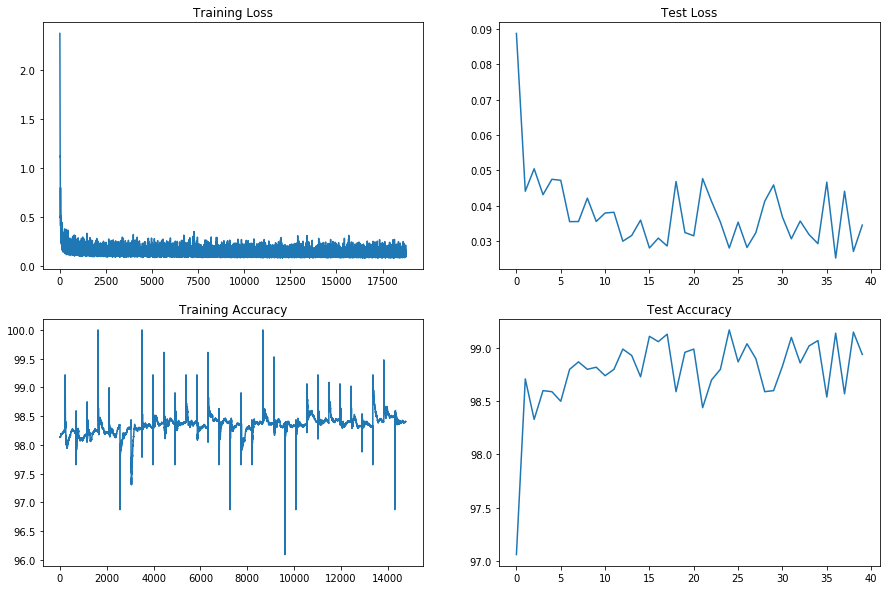

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

batchmates Mounika, Meenakshi, Vivek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


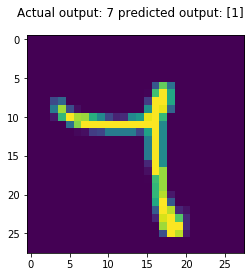

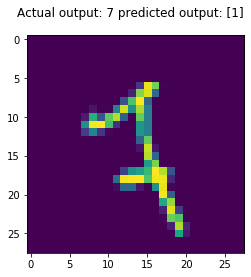

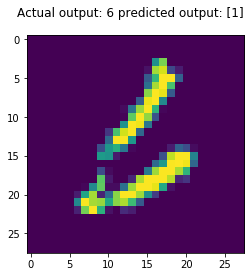

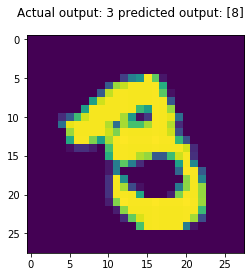

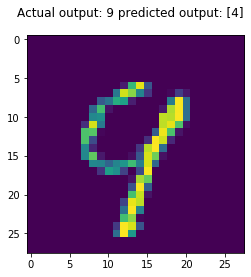

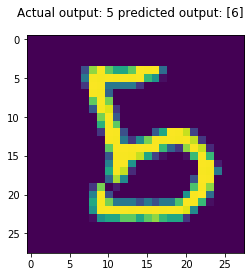

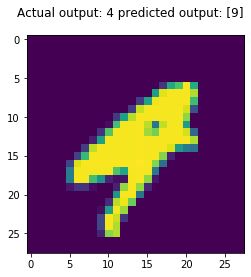

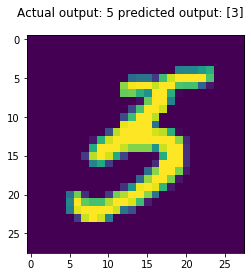

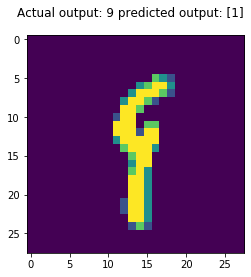

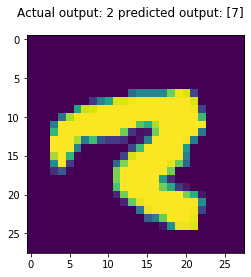

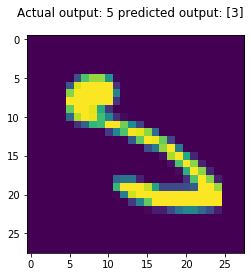

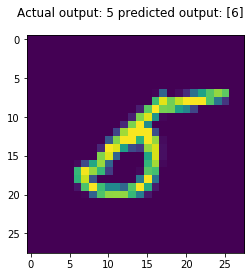

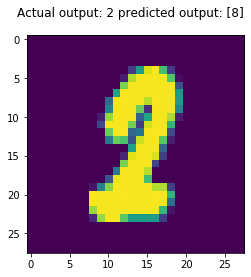

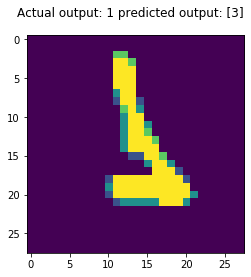

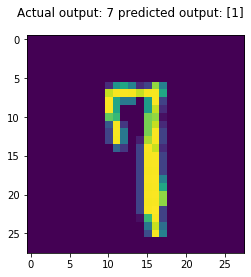

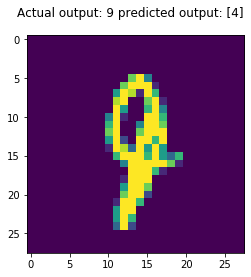

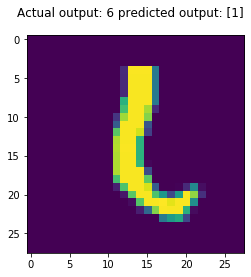

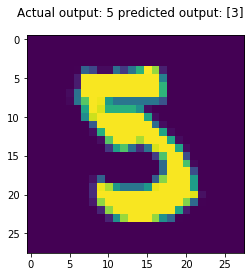

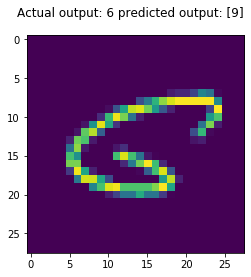

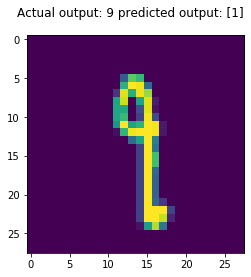

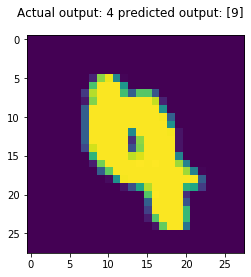

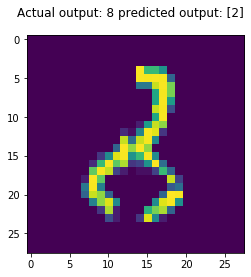

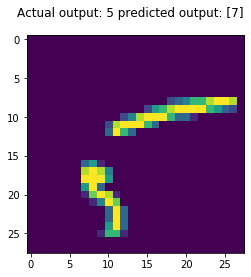

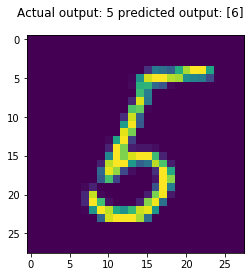

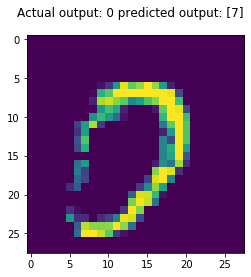

In [10]:
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim= True)
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " predicted output: " + str(predx[i]))

                count = count+1